In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

In [2]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

(array([ 79062.,      0.,      0.,      0.,      0., 126893.,      0.,
             0.,      0.,  85286.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

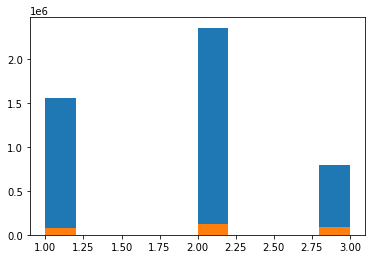

In [7]:
import matplotlib.pyplot as plt
plt.hist(train['lane_count'])
plt.hist(test['lane_count'])

<AxesSubplot:>

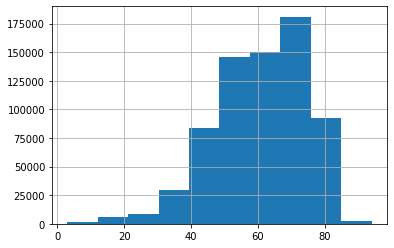

In [23]:
tp = train[train['maximum_speed_limit'] == 80]
tp['target'].hist()

<AxesSubplot:>

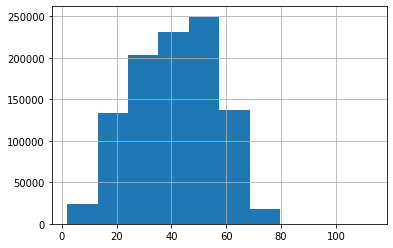

In [24]:
tp = train[train['maximum_speed_limit'] == 70]
tp['target'].hist()

<AxesSubplot:>

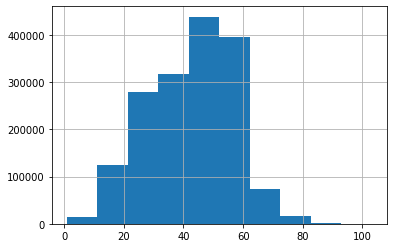

In [25]:
tp = train[train['maximum_speed_limit'] == 60]
tp['target'].hist()

<AxesSubplot:>

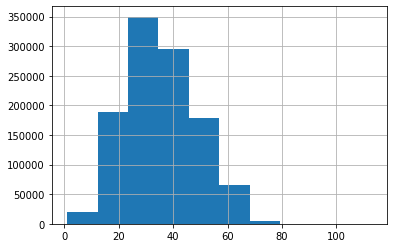

In [32]:
tp = train[train['maximum_speed_limit'] == 50]
tp['target'].hist()

<AxesSubplot:>

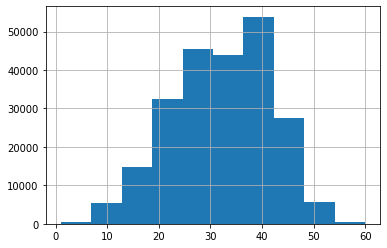

In [27]:
tp = train[train['maximum_speed_limit'] == 30]
tp['target'].hist()

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed(speed):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit"
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["maximum_speed_limit"]==speed]
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date"], axis=1)

    test = test[test["maximum_speed_limit"]==speed]
    test_id = test['id']
    test = test.drop(['id',"base_date"], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
    r1.fit(X_train,y_train)
    
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    
    prediction_table['target'] = r1.predict(test)
    prediction_table.to_csv(f'./target{speed}.csv')
    print(f'save {speed}')

In [37]:
rf_speed(80)
rf_speed(70)
rf_speed(60)
rf_speed(50)
rf_speed(30) # voting 

3.183664392208864
save 80
3.7756478067256523
save 70
3.5392702067268336
save 60
3.7536409194748983
save 50
2.878623274703425
save 30


In [33]:
ans = pd.concat([pd.read_csv('target30.csv'),pd.read_csv('target50.csv'),
          pd.read_csv('target60.csv'),pd.read_csv('target70.csv'),
          pd.read_csv('target80.csv')]).drop('Unnamed: 0',axis=1)
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans.to_csv('./submit.csv')

In [ ]:
train['base_date'].value_counts

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

In [41]:
from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(train['start_longitude'],train['start_latitude'])]
end = [(i-90,j) for i,j in zip(train['end_longitude'],train['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
train['distance'] = distance

In [42]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted,target,distance
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,32400.0,3,제3교래교,없음,제3교래교,없음,52.0,0.030806
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0,광양사거리,있음,KAL사거리,없음,30.0,0.484324
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0,창고천교,없음,상창육교,없음,61.0,0.722014
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0,남양리조트,없음,서현주택,없음,20.0,0.117894
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0,애월샷시,없음,애월입구,없음,38.0,0.402515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,0.0,0,대림사거리,없음,금덕해운,없음,20.0,0.497979
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,43200.0,3,광삼교,없음,광삼교,없음,65.0,0.058066
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,0.0,0,고성교차로,없음,성산교차로,없음,30.0,0.275295
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,0.0,0,제6광령교,없음,관광대학입구,없음,73.0,0.209894
